In [24]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotting import show_img

FIGURE_DIR = "figures/"
TRAIN_DATA_DIR = "train_data/"

def prepare_df(df):
    df.columns = df.columns.str.replace("_", " ")
    # df.columns = df.columns.str.replace("loss", "")
    df.columns = df.columns.str.strip()
    return df

def extract_latent_dim(filename):
    try:
        return filename.split("_")[3].split("latent")[1]
    except IndexError:
        return None

MODEL_DIR = "trained_models/"

## Load all VAE and AE training data

In [116]:
filenames = [
    "VAE_CELL_CNN_latent2_mean_loss_data.csv",
    "VAE_CELL_CNN_latent8_mean_loss_data.csv",
    "VAE_CELL_CNN_latent16_mean_loss_data.csv",
    "VAE_CELL_CNN_latent32_mean_loss_data.csv",
    "VAE_CELL_CNN_latent64_mean_loss_data.csv",
    "VAE_CELL_CNN_latent128_mean_loss_data.csv",
    "VAE_CELL_CNN_latent256_mean_loss_data.csv",
    # "CELL_CNN_AutoEncoder_latent256_mean_loss_data.csv",
]

# filenames_ae_b0 = [
#     "CELL_CNN_AutoEncoder_latent256_mean_loss_data.csv",
#     ""
# ]

dfs = [pd.read_csv(TRAIN_DATA_DIR + filename) for filename in filenames]



In [117]:
# combine all the dataframes
df_overall = pd.DataFrame(columns=["latent_dim"] + dfs[0].columns.tolist())
for filename, df in zip(filenames, dfs):
    
    latent_dim = extract_latent_dim(filename)
    df["latent_dim"] = latent_dim
    df_overall = pd.concat([df_overall, df])



C:\Users\Otto\AppData\Local\Temp\ipykernel_19236\2344924638.py:7: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



In [118]:

# round to 2 decimal places
df_overall = df_overall.round(3)
df_overall



,latent_dim,train_loss,train_mse_loss,train_kld_loss,val_loss,val_mse_loss,val_kld_loss,test_loss,test_mse_loss,test_kld_loss
0,2,217.022,209.691,7.331,197.489,190.514,6.975,184.232,177.776,6.456
1,2,195.241,188.399,6.842,193.323,186.466,6.858,184.232,177.776,6.456
2,2,192.215,185.774,6.441,190.925,184.502,6.422,184.232,177.776,6.456
3,2,190.937,184.701,6.236,190.577,184.456,6.121,184.232,177.776,6.456
4,2,192.659,186.240,6.420,191.326,184.803,6.523,184.232,177.776,6.456
...,...,...,...,...,...,...,...,...,...,...
45,256,87.635,54.181,33.454,88.280,54.740,33.541,88.177,54.581,33.596
46,256,87.598,54.141,33.458,88.030,54.538,33.492,88.177,54.581,33.596
47,256,87.581,54.131,33.450,88.353,54.308,34.045,88.177,54.581,33.596
48,256,87.544,54.087,33.457,88.211,54.735,33.476,88.177,54.581,33.596


### Plot of all latent dimensions training loss

In [119]:
# there are 50 epochs
# use index as x-axis
fig = px.line(df_overall, x=df_overall.index, y="train_loss", color="latent_dim")
fig.update_layout(
    title="Training Loss vs Epochs",
    xaxis_title="Epochs",
    yaxis_title="Training Loss",
)
fig.show()
fig.write_image(FIGURE_DIR + "training_loss_vs_epochs.png")


### Table of the loss metrics on the last epoch

In [120]:
# extract all the "last" rows
df_last = df_overall.groupby("latent_dim").tail(1)
prepare_df(df_last).to_latex(index=False, escape=False, buf=FIGURE_DIR + "final_loss_table.tex", float_format="%.2f")
df_last



# fig = px.bar(df_last, x="name", y="train_loss")
# fig.update_layout(
#     title="Final Training Loss",
#     xaxis_title="Latent Dimension",
#     yaxis_title="Training Loss",
# )
# fig.show()

,latent dim,train loss,train mse loss,train kld loss,val loss,val mse loss,val kld loss,test loss,test mse loss,test kld loss
49,2,183.696,177.331,6.365,184.052,177.590,6.462,184.232,177.776,6.456
49,8,115.046,98.375,16.671,116.981,100.384,16.596,117.100,100.518,16.581
49,16,94.840,69.904,24.936,96.652,71.908,24.743,96.395,71.656,24.738
49,32,87.858,55.672,32.186,88.425,56.046,32.379,88.587,56.218,32.369
49,64,87.029,53.511,33.518,88.072,54.143,33.929,88.067,54.141,33.926
49,128,87.947,54.502,33.445,88.328,54.815,33.513,88.241,54.737,33.504
49,256,87.545,54.090,33.455,88.062,54.504,33.558,88.177,54.581,33.596


In [121]:
# investigate 32 vs 256 latent dim

df_overall_32 = df_overall[df_overall["latent_dim"] == "32"]
df_overall_256 = df_overall[df_overall["latent_dim"] == "256"]

df_overall_32

# plot train_loss, train_mse_loss and train_kld_loss in the same plot
fig = px.line(df_overall_32, x=df_overall_32.index, y=["train_loss", "train_mse_loss", "train_kld_loss"], title="32 Latent Dim Train Loss vs Epochs", labels={"value": "Loss", "variable": "Loss Type"})
fig.update_layout(
    xaxis_title="Epochs",
    yaxis_title="Loss",
)
fig.show()

fig = make_subplots(rows=1, cols=2, subplot_titles=("Latent 32", "Latent 256"))
# plot train_loss, train_mse_loss and train_kld_loss in the same plot
fig.add_trace(go.Scatter(x=df_overall_32.index, y=df_overall_32["train_loss"], mode="lines", name="train_loss"), row=1, col=1)
fig.add_trace(go.Scatter(x=df_overall_32.index, y=df_overall_32["train_mse_loss"], mode="lines", name="train_mse_loss"), row=1, col=1)
fig.add_trace(go.Scatter(x=df_overall_32.index, y=df_overall_32["train_kld_loss"], mode="lines", name="train_kld_loss"), row=1, col=1)

fig.add_trace(go.Scatter(x=df_overall_256.index, y=df_overall_256["train_loss"], mode="lines", name="train_loss"), row=1, col=2)
fig.add_trace(go.Scatter(x=df_overall_256.index, y=df_overall_256["train_mse_loss"], mode="lines", name="train_mse_loss"), row=1, col=2)
fig.add_trace(go.Scatter(x=df_overall_256.index, y=df_overall_256["train_kld_loss"], mode="lines", name="train_kld_loss"), row=1, col=2)

fig.update_layout(
    xaxis_title="Epochs",
    yaxis_title="Loss",
)
fig.update_xaxes(title_text="Epochs", row=1, col=1)
fig.update_xaxes(title_text="Epochs", row=1, col=2)
fig.update_yaxes(title_text="Loss", row=1, col=1)
fig.update_yaxes(title_text="Loss", row=1, col=2)

fig.show()

# save the figure as png
fig.write_image(FIGURE_DIR + "32_vs_256_latent_dim_loss.png")



# Compare models reconstruction on some samples

In [122]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from dataset_tools import OwnDataset, make_train_test_val_split
import matplotlib

cuda = torch.cuda.is_available()

In [123]:
tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    # transforms.Lambda(lambda x: x.view(-1)) # notice that we dont flatten when we are going to use CNN
])

# dataset = OwnDataset(transform=tf)
dataset = OwnDataset(transform=tf, path=r"C:\Users\Otto\Desktop\Fagprojekt_data\labelled_data")

batch_size = 64
train_subset, test_subset, val_subset = make_train_test_val_split(dataset)


train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, pin_memory=cuda, drop_last=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=True, pin_memory=cuda, drop_last=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True, pin_memory=cuda, drop_last=True)

print(len(dataset), len(train_loader), len(test_loader), len(val_loader))



488396 4883 1526 1221


## Load the models we want to compare

In [124]:
# there are 3 different unsupervised models to choose from on the cell dataset
from models import VAE_CELL_CNN, VAE_LAFARGE, CELL_CNN_AutoEncoder
from loss_functions import loss_function
# import mse loss


# now we load the saved models into the model class
MODEL_DIR = "trained_models/"


# latent size 2
vae_cnn_own_2 = VAE_CELL_CNN(input_dim=(3,68,68), hidden_dim=4, latent_dim=2)
vae_cnn_own_2.load_state_dict(torch.load(MODEL_DIR + f"{vae_cnn_own_2.__class__.__name__}_latent{vae_cnn_own_2.latent_dim}_mean_best_model.pth"))

# latent size 8
vae_cnn_own_8 = VAE_CELL_CNN(input_dim=(3,68,68), hidden_dim=16, latent_dim=8)
vae_cnn_own_8.load_state_dict(torch.load(MODEL_DIR + f"{vae_cnn_own_8.__class__.__name__}_latent{vae_cnn_own_8.latent_dim}_mean_best_model.pth"))

# latent size 16
vae_cnn_own_16 = VAE_CELL_CNN(input_dim=(3,68,68), hidden_dim=32, latent_dim=16)
vae_cnn_own_16.load_state_dict(torch.load(MODEL_DIR + f"{vae_cnn_own_16.__class__.__name__}_latent{vae_cnn_own_16.latent_dim}_mean_best_model.pth"))

# latent size 32
vae_cnn_own_32 = VAE_CELL_CNN(input_dim=(3,68,68), hidden_dim=64, latent_dim=32)
vae_cnn_own_32.load_state_dict(torch.load(MODEL_DIR + f"{vae_cnn_own_32.__class__.__name__}_latent{vae_cnn_own_32.latent_dim}_mean_best_model.pth"))

# latent size 64
vae_cnn_own_64 = VAE_CELL_CNN(input_dim=(3,68,68), hidden_dim=128, latent_dim=64)
vae_cnn_own_64.load_state_dict(torch.load(MODEL_DIR + f"{vae_cnn_own_64.__class__.__name__}_latent{vae_cnn_own_64.latent_dim}_mean_best_model.pth"))

# latent size 128
vae_cnn_own_128 = VAE_CELL_CNN(input_dim=(3,68,68), hidden_dim=256, latent_dim=128)
vae_cnn_own_128.load_state_dict(torch.load(MODEL_DIR + f"{vae_cnn_own_128.__class__.__name__}_latent{vae_cnn_own_128.latent_dim}_mean_best_model.pth"))


# latent size 256
model = VAE_CELL_CNN(input_dim=(3,68,68), hidden_dim=512, latent_dim=256)
model.load_state_dict(torch.load(MODEL_DIR + f"{model.__class__.__name__}_latent{model.latent_dim}_mean_best_model.pth"))
# vae_lafarge = VAE_LAFARGE(input_dim=(3,68,68), hidden_dim=512, latent_dim=256)
# vae_lafarge.load_state_dict(torch.load(MODEL_DIR + f"{vae_lafarge.__class__.__name__}_latent{vae_lafarge.latent_dim}_best_model.pth"))

ae_cnn_own = CELL_CNN_AutoEncoder(latent_dim=256)
ae_cnn_own.load_state_dict(torch.load(MODEL_DIR + f"{ae_cnn_own.__class__.__name__}_latent{ae_cnn_own.latent_dim}_mean_best_model.pth"))


vae_cnn_own_b0 = VAE_CELL_CNN(input_dim=(3,68,68), hidden_dim=512, latent_dim=256)
vae_cnn_own_b0.load_state_dict(torch.load(MODEL_DIR + f"{vae_cnn_own_b0.__class__.__name__}_latent{vae_cnn_own_b0.latent_dim}_b0_best_model.pth"))




# models = [vae_cnn_own]
# models = [vae_cnn_own_2, vae_cnn_own_64, vae_cnn_own_256, vae_cnn_own_b0, ae_cnn_own]
# models = [ae_cnn_own]



<All keys matched successfully>

## Evaluate performance on test set given by the loss

random image number: 230635


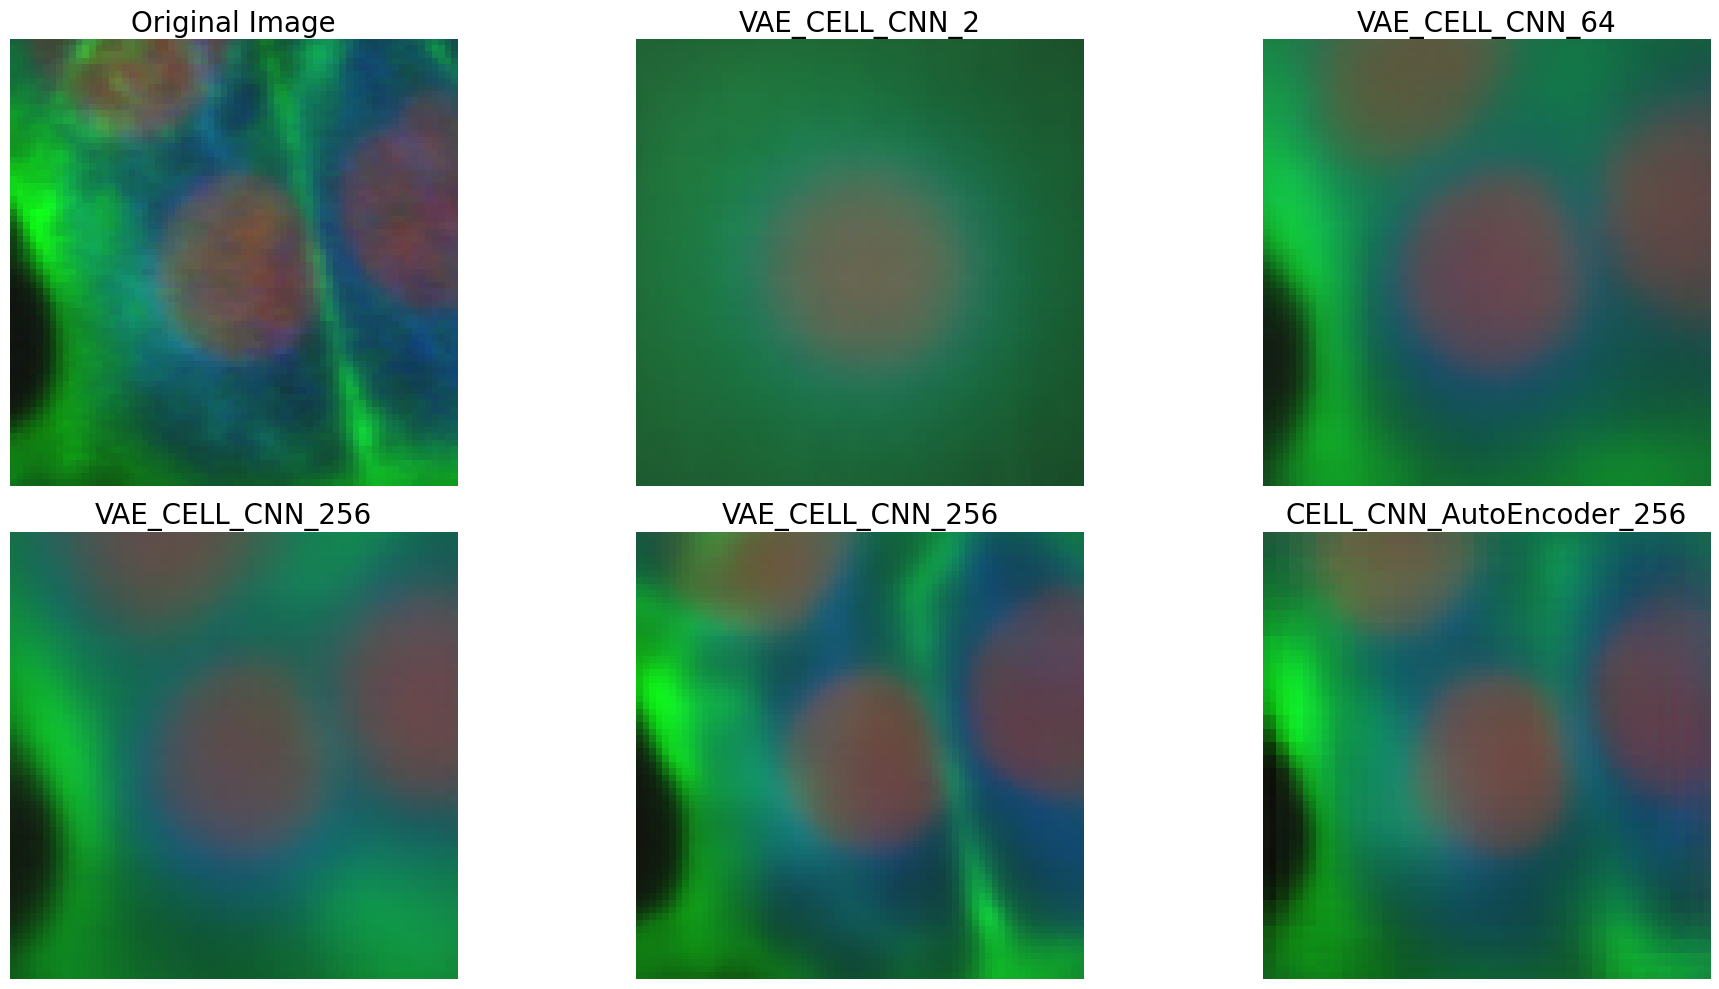

In [167]:
models = [vae_cnn_own_2, vae_cnn_own_64, model, vae_cnn_own_b0, ae_cnn_own]

# Given an input image, create a reconstruction of the image using each model
def get_name(model):
    return model.__class__.__name__ + f"_{model.latent_dim}"


def reconstruct_image(model, image):
    with torch.no_grad():
        model.eval()
        image = image.unsqueeze(0)
        output = model(image)
        if isinstance(output, dict):
            x_hat = output["x_hat"]
        else:
            x_hat = output
        return x_hat.squeeze(0)
    
x, y = next(iter(train_loader))


# plot the original image and the reconstructed image
# reconstruct_image(vae_cnn_own, x[0]).shape
reconstruct_image(ae_cnn_own, x[0]).shape




def plot_reconstructions(models, image, save=False):
    fig, ax = plt.subplots(1, len(models)+1, figsize=(20, 5))
    ax[0].imshow(image.permute(1, 2, 0))
    ax[0].set_title("Original Image")
    ax[0].set_axis_off()
    for i, model in enumerate(models):
        x_hat = reconstruct_image(model, image)
        ax[i+1].imshow(x_hat.permute(1, 2, 0))
        ax[i+1].set_title(get_name(model))
        ax[i+1].set_axis_off()
    plt.axis("off")
    if save:
        plt.savefig(FIGURE_DIR + "reconstruction_comparison.png")
    plt.show()


# plot reconstructions with 2 rows
def plot_reconstructions_2rows(models, image, save=False):
    fig, ax = plt.subplots(2, (len(models)+1)//2, figsize=(20, 10))
    ax[0, 0].imshow(image.permute(1, 2, 0))
    ax[0, 0].set_title("Original Image", fontsize=20)
    ax[0, 0].set_axis_off()
    for i, model in enumerate(models, 1):
        x_hat = reconstruct_image(model, image)
        ax[i//3, i%3].imshow(x_hat.permute(1, 2, 0))
        ax[i//3, i%3].set_title(get_name(model), fontsize=20)
        ax[i//3, i%3].set_axis_off()

    plt.axis("off")
    if save:
        plt.tight_layout()
        plt.savefig(FIGURE_DIR + "reconstruction_comparison.png")
    plt.show()



random_image_id = np.random.randint(0, len(dataset))
print(f"random image number: {random_image_id}")
plot_reconstructions_2rows(models, dataset[random_image_id][0], save=True)

# this is just for use to later get some images
numbers = []


# Classification data analysis

## Gather all the train and test accuracies in joint table

In [2]:

filenames = ["LatentClassifier_2_latent2_mean_data.csv", 'LatentClassifier_2_latent32_mean_data.csv', 'LatentClassifier_2_latent256_mean_data.csv', "CELL_CNN_CLASSIFIER_data.csv"]

dfs = [pd.read_csv(TRAIN_DATA_DIR + filename) for filename in filenames]

In [3]:
def extract_latent_dim(filename):
    try:
        return filename.split("_")[2].split("latent")[1]
    except IndexError:
        return 0

# combine all the dataframes
df_overall = pd.DataFrame(columns=["latent_dim"] + dfs[0].columns.tolist())

for filename, df in zip(filenames, dfs):
    latent_dim = extract_latent_dim(filename)
    df["latent_dim"] = latent_dim
    df_overall = pd.concat([df_overall, df])


C:\Users\Otto\AppData\Local\Temp\ipykernel_19856\702757164.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_overall = pd.concat([df_overall, df])


In [220]:
# filenames[0].split("_")[2].split("latent")[1]

# extract_latent_dim(filenames[1])


In [5]:
df_overall
df_last = df_overall.groupby("latent_dim", dropna=False).tail(1)
df_last

# train accuracies with test accuracies as horizontal lines
fig = px.line(df_overall, x=df_overall.index, y="train_accuracy", color="latent_dim")
# fig.add_hline(y=df_last["test_accuracy"].values[0], line_dash="dot", annotation_text="test_accuracy 2", annotation_position="bottom right")
# fig.add_hline(y=df_last["test_accuracy"].values[1], line_dash="dot", annotation_text="test_accuracy 256", annotation_position="bottom right")
# fig.add_hline(y=df_last["test_accuracy"].values[2], line_dash="dot", annotation_text="test_accuracy 0", annotation_position="bottom right")

fig.update_layout(
    title="Training Accuracy vs Epochs",
    xaxis_title="Epochs",
    yaxis_title="Accuracy",
)
fig.show()
fig.write_image(FIGURE_DIR + "training_accuracy_vs_epochs.png")

In [6]:
df_last
# save df as latex
prepare_df(df_last).to_latex(index=False, escape=False, buf=FIGURE_DIR + "final_accuracy_table.tex", float_format="%.2f")

In [7]:
df_overall

,latent_dim,train_loss,val_loss,test_loss,train_accuracy,val_accuracy,test_accuracy
0,2,1.352088,1.308211,1.219038,0.611273,0.619203,0.648187
1,2,1.290702,1.287029,1.219038,0.626023,0.626574,0.648187
2,2,1.264726,1.256555,1.219038,0.634715,0.637029,0.648187
3,2,1.247469,1.249734,1.219038,0.641680,0.638386,0.648187
4,2,1.242581,1.247017,1.219038,0.642920,0.639857,0.648187
...,...,...,...,...,...,...,...
45,0,0.075877,3.203486,3.012039,0.980030,0.783925,0.788024
46,0,0.074358,3.173129,3.012039,0.980452,0.784539,0.788024
47,0,0.071013,3.113744,3.012039,0.981527,0.777859,0.788024
48,0,0.076321,3.773053,3.012039,0.980203,0.778486,0.788024


# inference

In [4]:
import torch
from models import VAE_CELL_CNN
from dataset_tools import OwnDataset, make_train_test_val_split
from torchvision import transforms
from torch.utils.data import DataLoader

tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    # transforms.Lambda(lambda x: x.view(-1)) # notice that we dont flatten when we are going to use CNN
])

# dataset = OwnDataset(transform=tf)
dataset = OwnDataset(transform=tf, path=r"C:\Users\Otto\Desktop\Fagprojekt_data\labelled_data")

batch_size = 96
train_subset, test_subset, val_subset = make_train_test_val_split(dataset)


train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True, drop_last=True)

print(len(dataset), len(train_loader), len(test_loader), len(val_loader))


model = VAE_CELL_CNN(input_dim=(3,68,68), hidden_dim=512, latent_dim=256)
model.load_state_dict(torch.load(MODEL_DIR + f"{model.__class__.__name__}_latent{model.latent_dim}_mean_best_model.pth"))
# vae_lafarge = VAE_LAFARGE(input_dim=(3,68,68), hidden_dim=512, latent_dim=256)



488396 3255 1017 814


<All keys matched successfully>

In [12]:
import torch
# to run inference on the trained model
class Inference:
    def __init__(self, model, test_loader, num_samples=10):
        self.model = model
        self.model.eval()
        self.model.to('cpu')
        self.num_samples = num_samples
        self.test_loader = test_loader
        self.samples = self.generate_samples()
        
    def generate_samples(self):
        class_ids = list(test_loader.dataset.dataset.dataset.class_to_idx.values())
        samples = {str(idx_id): {"x": torch.Tensor(),"x_hat": torch.Tensor(), "mu": torch.Tensor(), "sigma": torch.Tensor(), "z": torch.Tensor()} for idx_id in class_ids}
        with torch.no_grad():
            for batch_x, batch_y in self.test_loader:
                if all([len(samples[str(idx_id)]["x"]) >= self.num_samples for idx_id in class_ids]):
                    break
                # if cuda:
                #     batch_x = batch_x.cuda()
                output = self.model(batch_x)
                batch_x_hat, batch_mu, batch_sigma, batch_z = output["x_hat"], output["mu"], output["sigma"], output["z"]
                print([len(samples[str(idx_id)]["x"]) for idx_id in class_ids ])
                for x, x_hat, y, mu, sigma, z in zip(batch_x, batch_x_hat, batch_y, batch_mu, batch_sigma, batch_z):
                    if len(samples[str(y.item())]["x"]) < self.num_samples:
                        samples[str(y.item())]["x"] = torch.cat((samples[str(y.item())]["x"], x.unsqueeze(0)), dim=0)
                        samples[str(y.item())]["x_hat"] = torch.cat((samples[str(y.item())]["x_hat"], x_hat.unsqueeze(0)), dim=0)
                        samples[str(y.item())]["mu"] = torch.cat((samples[str(y.item())]["mu"], mu.unsqueeze(0)), dim=0)
                        samples[str(y.item())]["sigma"] = torch.cat((samples[str(y.item())]["sigma"], sigma.unsqueeze(0)), dim=0)
                        samples[str(y.item())]["z"] = torch.cat((samples[str(y.item())]["z"], z.unsqueeze(0)), dim=0)
                    else:
                        break


        return samples

In [13]:
# from inference import Inference

inference = Inference(model, test_loader)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 0, 0, 10, 1, 0, 1, 0, 3, 0, 4, 0, 0]
[2, 0, 0, 10, 1, 0, 1, 0, 3, 0, 4, 0, 0]
[2, 0, 0, 10, 2, 0, 1, 0, 3, 0, 4, 0, 0]
[2, 0, 0, 10, 2, 0, 1, 0, 3, 0, 4, 0, 0]
[2, 0, 0, 10, 2, 0, 1, 0, 4, 0, 4, 0, 0]
[2, 0, 0, 10, 2, 0, 2, 0, 4, 0, 4, 0, 0]
[2, 0, 0, 10, 2, 0, 2, 0, 5, 0, 4, 0, 0]
[2, 0, 0, 10, 2, 0, 2, 0, 5, 0, 4, 0, 0]
[2, 0, 0, 10, 2, 0, 3, 0, 5, 0, 4, 0, 0]
[2, 0, 0, 10, 2, 0, 4, 0, 5, 0, 4, 0, 0]
[2, 0, 0, 10, 2, 0, 4, 0, 5, 0, 4, 0, 0]
[2, 0, 0, 10, 2, 0, 4, 0, 5, 0, 4, 0, 0]
[2, 0, 0, 10, 2, 0, 4, 0, 5, 0, 4, 0, 1]
[2, 0, 0, 10, 2, 0, 4, 0, 5, 0, 5, 0, 1]
[2, 0, 1, 10, 2, 0, 4, 0, 5, 0, 6, 0, 1]
[2, 0, 1, 10, 2, 0, 4, 0, 5, 0, 6, 0, 1]
[2, 0, 2, 10, 2, 0, 4, 0, 5, 0, 7, 0, 1]
[2, 0, 2, 10, 2, 0, 4, 0, 5, 0, 7, 0, 1]
[2, 0, 2, 10, 2, 0, 4, 0, 5, 0, 7, 0, 1]
[2, 0, 2, 10, 2, 0, 4, 1, 5, 0, 8, 0, 1]
[2, 1, 2, 10, 4, 0, 4, 1, 5, 1, 8, 0, 1]
[2, 1, 2, 10, 4, 0, 4, 1, 5, 1, 8, 0, 1]
[2, 1, 2, 10, 4, 0, 4, 1, 5, 1, 9, 0, 1]
[2, 1, 2, 10, 4, 

In [14]:
samples = inference.samples

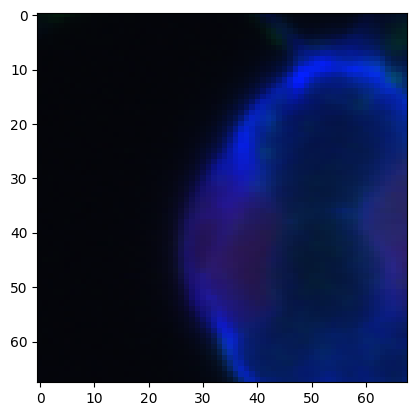

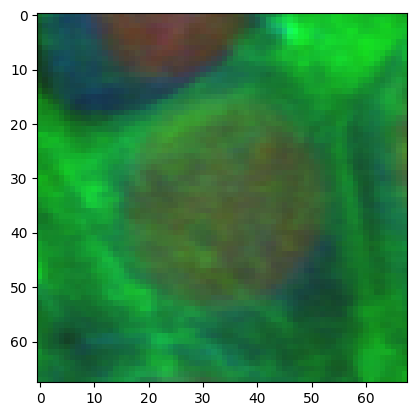

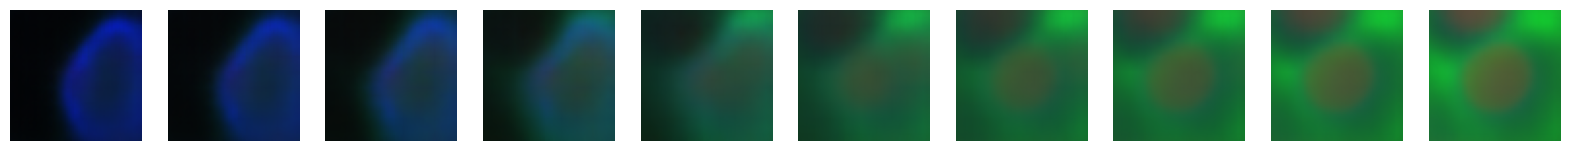

In [50]:
# interpolate between two images in the latent space
from scipy.interpolate import interp1d, interp2d

def interpolate_latent(model, z1, z2, num_steps=10):
    zs = [(1-t) * z1 + t * z2 for t in np.linspace(0, 1, num_steps)]

    with torch.no_grad():
        model.eval()
        x_hats = []
        for z in zs:
            x_hat = model.decode(z.unsqueeze(0))
            x_hats.append(x_hat)
        return x_hats

# interpolate between two images in the latent space
x1 = samples["0"]["x"][0]
x2 = samples["3"]["x"][3]

z1 = samples["0"]["z"][0]
z2 = samples["3"]["z"][3]

mu_1 = samples["0"]["mu"][0]
mu_2 = samples["3"]["mu"][3]

show_img(x1)
show_img(x2)

x_hats = interpolate_latent(model, mu_1, mu_2, num_steps=10)

fig, ax = plt.subplots(1, 10, figsize=(20, 5))
for i, x_hat in enumerate(x_hats):
    ax[i].imshow(x_hat.squeeze().permute(1, 2, 0))
    ax[i].set_axis_off()
plt.show()




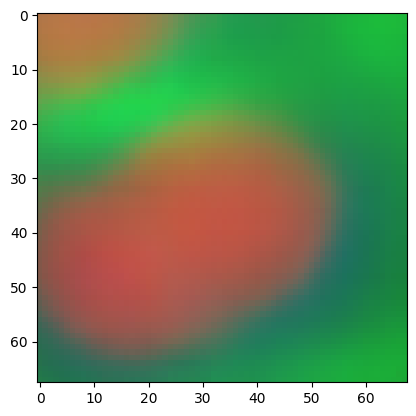

In [37]:
show_img(model.decode(z1.unsqueeze(0)).squeeze(0).detach())

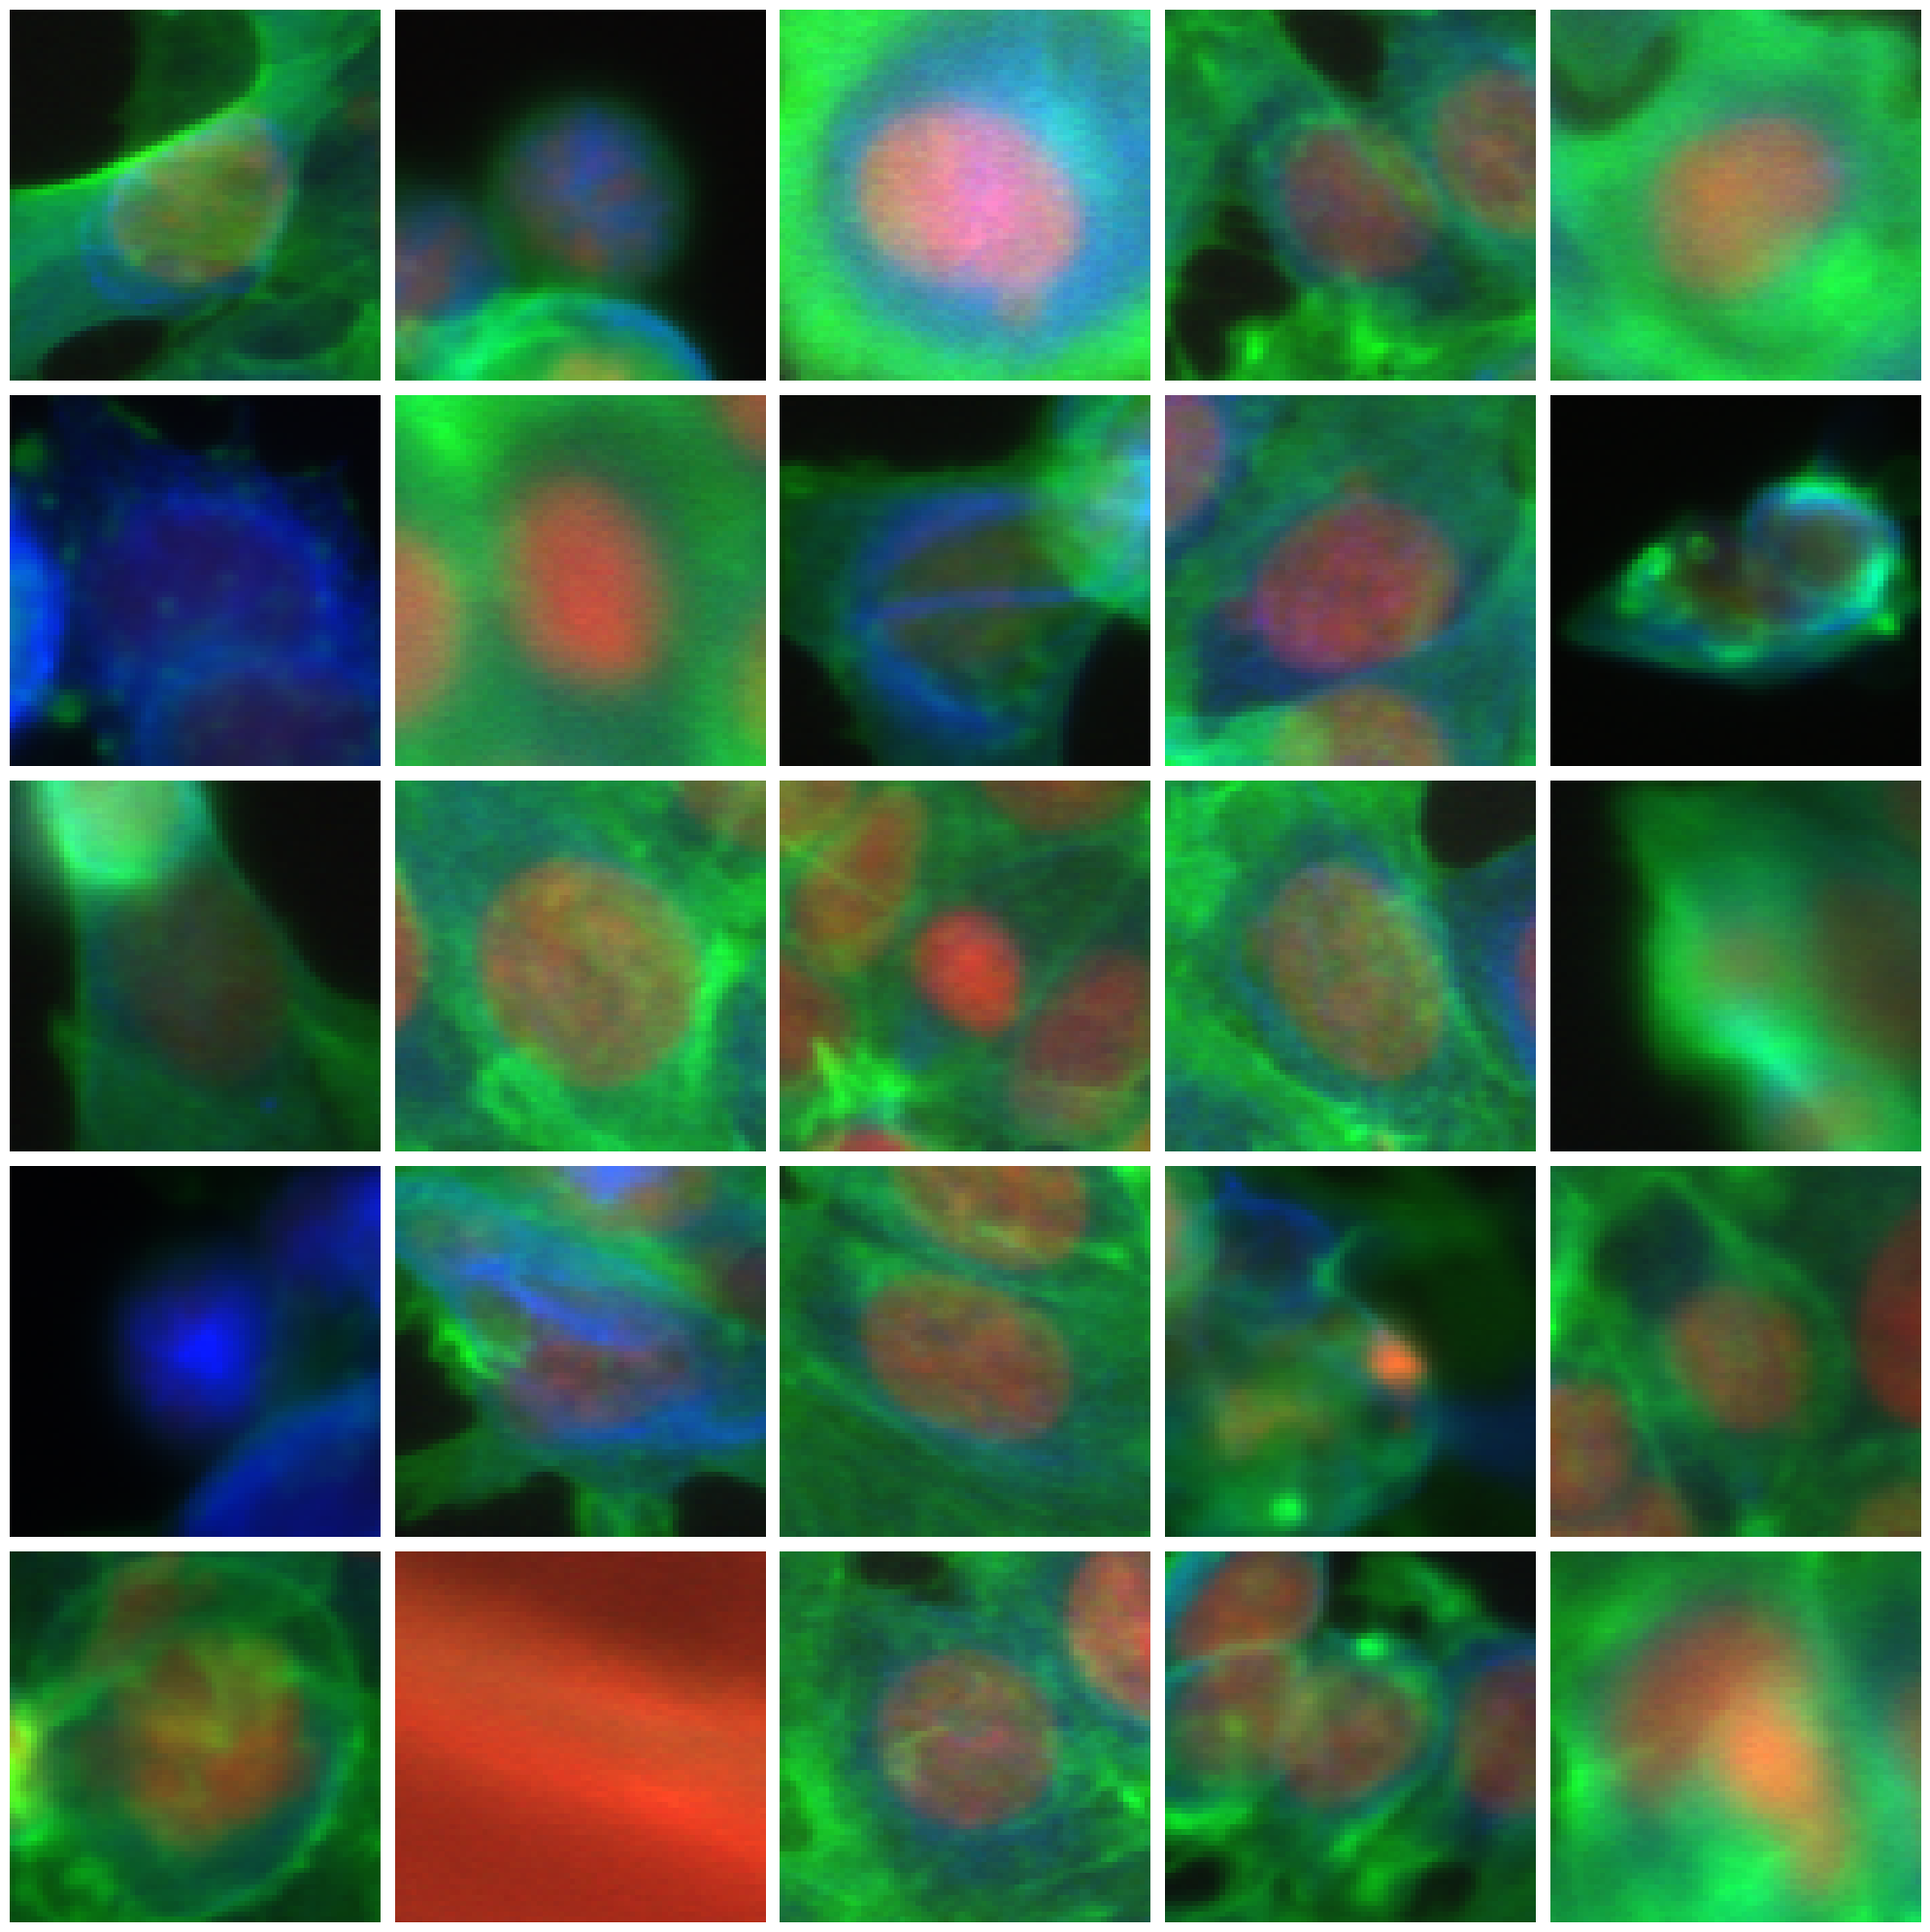

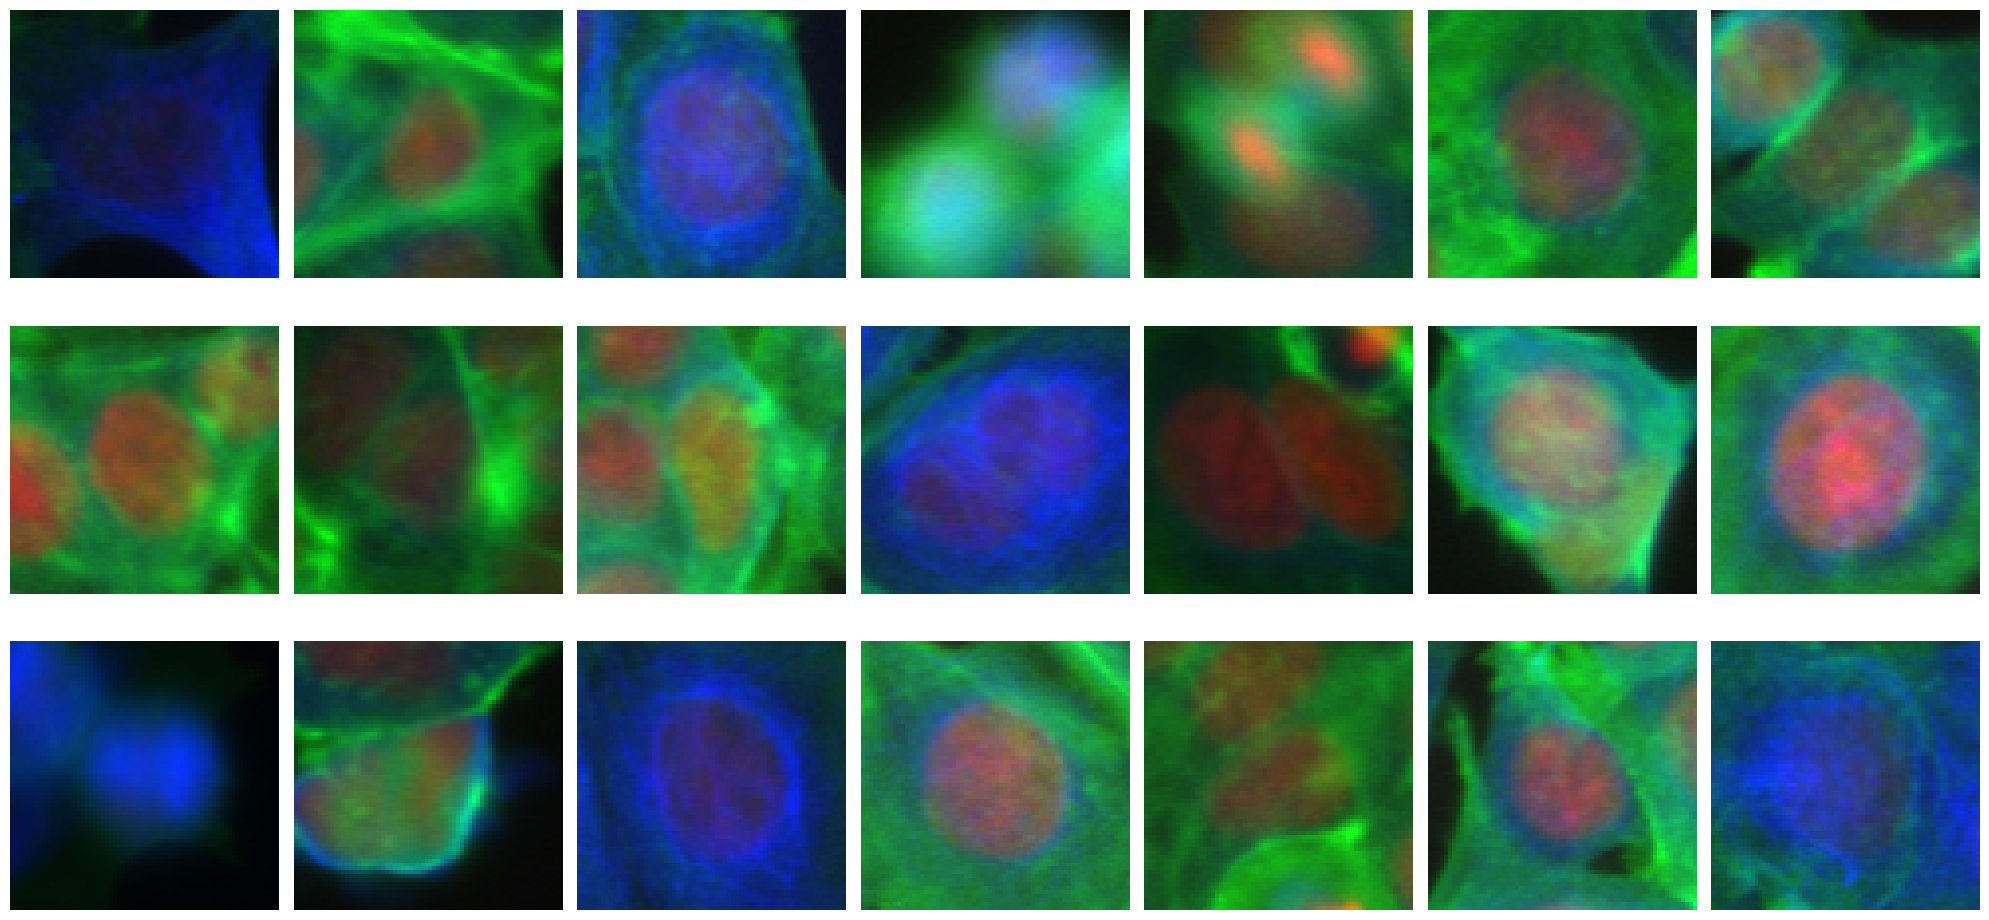

In [65]:
# make a 5x5 grid of random images

fig, ax = plt.subplots(5, 5, figsize=(20, 20))
for i in range(5):
    for j in range(5):
        idx = np.random.randint(0, len(dataset))
        x = dataset[idx][0]
        ax[i, j].imshow(x.permute(1, 2, 0))
        ax[i, j].set_axis_off()
plt.tight_layout()
plt.savefig(FIGURE_DIR + "random_images.png")


# 3 x 7 grid of random images
fig, ax = plt.subplots(3, 7, figsize=(20, 10))
for i in range(3):
    for j in range(7):
        idx = np.random.randint(0, len(dataset))
        x = dataset[idx][0]
        ax[i, j].imshow(x.permute(1, 2, 0))
        ax[i, j].set_axis_off()
plt.tight_layout()
plt.savefig(FIGURE_DIR + "random_images_3x7.png")